# pyBMS
## Imports and general variables

In [14]:
# Imports
from BMS import *
import warnings
import pickle as pkl
import seaborn as sns
import multiprocessing
from scipy.special import erf
from ipywidgets import interact, fixed, interact_manual,IntSlider,FloatSlider,Checkbox,HBox,VBox,interactive_output
from IPython.display import display,clear_output
from ipyparallel import Client
from os import listdir
from time import time
warnings.simplefilter("ignore")

#START IPYPARALLEL!
# c = Client()
# dview = c[:]
# with dview.sync_imports():
#     import numpy
# %px np = numpy

#Base Parameters 
randomV0 = 0
T=25000*4
N,leak,noise,threshold = 10,0.9,0.8,1.0
ew,iw = 0.5,0.0
amplitude,a,delta,v= 0.3,600,2000,0.3
sigma = 400

# 3 Currents (Zero, Bar, Gaussian)
current1=np.array([[0.0 if -a<=i*delta-v*t<=a else 0 for i in range(N)] for t in range(T)])
current2=np.array([[amplitude if -a<=i*delta-v*t<=a else 0 for i in range(N)] for t in range(T)])
current3=np.array([[amplitude*np.exp(-(((i*delta-v*t)**2)/(2*sigma**2))) for i in range(N)] for t in range(T)])

#Tau Correlation function

def tauCorr(raster,neuronA,neuronB,T):
    rA = sum(raster[neuronA])/T
    rB = sum(raster[neuronB])/T
    return np.abs(np.array([sum(raster[neuronA]*
                                np.concatenate([np.zeros(tau),raster[neuronB][:[-tau,T][tau==0]]]))/T - rA*rB 
                                    for tau in range(15)]))

### Testing first spike time

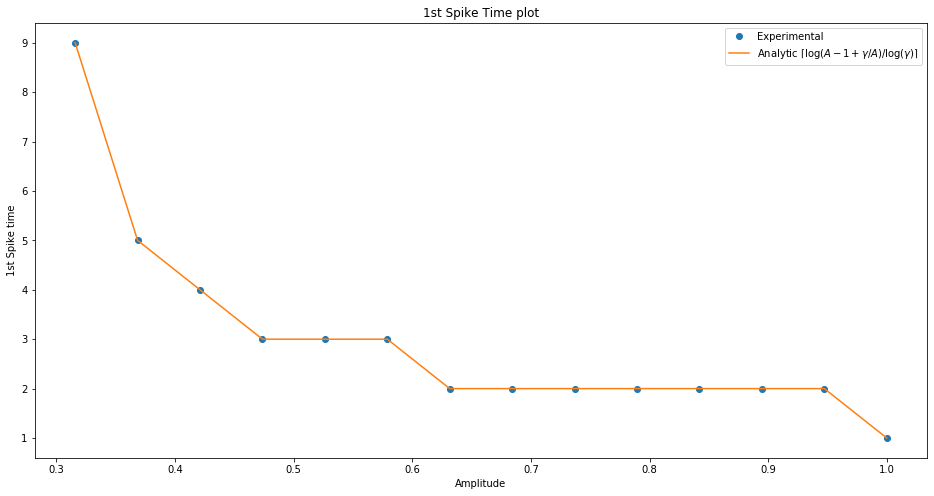

In [2]:
def amplitudeTesting(minA,maxA,steps):
    teoN,expN=[],[]
    for amplitude in np.linspace(minA,maxA,steps):
        mode = BMS(N,leak,noise*0,threshold,randomV0)
        mode.randomW(0.0)
        current= np.ones(N)*amplitude        
        raster= mode.new_raster(1000,current)
        expN.append(np.where(raster[0]==1)[0][0] if 1 in raster[0] else np.nan)
        teoN.append(np.ceil(np.log((amplitude-1+leak)/amplitude)/np.log(leak)))
    plt.figure(figsize=(16,8))
    plt.xlabel("Amplitude")
    plt.ylabel("1st Spike time")
    plt.title("1st Spike Time plot")
    plt.plot(np.linspace(minA,maxA,steps),expN,'o',label="Experimental")
    plt.plot(np.linspace(minA,maxA,steps),teoN,label="Analytic $\\left \\lceil{\\log{(A-1+\\gamma}/A)}/\\log(\\gamma)\\right \\rceil$")
    plt.legend()
    plt.savefig('FirstSpike.png')
    plt.show()
amplitudeTesting(0.0,1.0,20)
#interact_manual(amplitudeTesting,minA=fixed(0.0),maxA=(0.5,1.0,0.1),steps=(2,100,1))

### 3 Example pre-saved rasters

In [9]:
#Base 3 example rasters
if "raster1.pkl" not in listdir():#Raster without stimulus
    mode = BMS(N,leak,noise,threshold,0)
    mode.weights = np.array([[[[0,iw][abs(i-j)==2],ew][abs(i-j)==1] for j in range(N)] for i in range(N)])
    current1=np.array([[0.0 if -a<=i*delta-v*t<=a else 0 for i in range(N)] for t in range(T)])
    raster1 = mode.new_raster(T,current1)
    with open("raster1.pkl".format(ew),"wb") as WF:
        pkl.dump(raster1,WF)
with open("raster1.pkl","rb") as OF:
    raster1 = pkl.load(OF)
print("Raster 1 OK")

if "raster2.pkl" not in listdir(): #Raster with stimulus
    mode = BMS(N,leak,noise,threshold,0)
    mode.weights = np.array([[[[0,iw][abs(i-j)==2],ew][abs(i-j)==1] for j in range(N)] for i in range(N)])
    current2=np.array([[amplitude if -a<=i*delta-v*t<=a else 0 for i in range(N)] for t in range(T)])
    raster2 = mode.new_raster(T,current2)
    with open("raster2.pkl".format(ew),"wb") as WF:
        pkl.dump(raster2,WF)
with open("raster2.pkl","rb") as OF:
    raster2 = pkl.load(OF)
print("Raster 2 OK")

if "raster3.pkl" not in listdir(): #Raster with gaussian stimulus
    mode = BMS(N,leak,noise,threshold,0)
    mode.weights = np.array([[[[0,iw][abs(i-j)==2],ew][abs(i-j)==1] for j in range(N)] for i in range(N)])
    current3=np.array([[amplitude*np.exp(-(((i*delta-v*t)**2)/(2*sigma**2))) for i in range(N)] for t in range(T)])
    raster3 = mode.new_raster(T,current3)
    with open("raster3.pkl".format(ew),"wb") as WF:
        pkl.dump(raster3,WF)
with open("raster3.pkl","rb") as OF:
    raster3 = pkl.load(OF)
print("Raster 3 OK")

Raster 1 OK
Raster 2 OK
Raster 3 OK


### Pre saved rasters generator (with many parameters)

In [4]:
def createRaster(N,leak,noise,threshold,ew,iw,T):
    print("Rasters/RG{0}E{1}N{2} Starting".format(leak,ew,noise),end=' ')
    mode = BMS(N,leak,noise,threshold,0)
    mode.weights = np.array([[[[0,iw][abs(i-j)==2],ew][abs(i-j)==1] for j in range(N)] for i in range(N)])
    raster1 = mode.new_raster(T,current1)
    raster2 = mode.new_raster(T,current2)
    raster3 = mode.new_raster(T,current3)
    with open("Rasters/RG{0}E{1}N{2}C1.pkl".format(leak,ew,noise),"wb") as WF:
        pkl.dump(raster1,WF)
    print('OK!',end=' ')
    with open("Rasters/RG{0}E{1}N{2}C2.pkl".format(leak,ew,noise),"wb") as WF:
        pkl.dump(raster2,WF)
    print('OK!',end=' ')
    with open("Rasters/RG{0}E{1}N{2}C3.pkl".format(leak,ew,noise),"wb") as WF:
        pkl.dump(raster3,WF)
    print('OK!')
    print("Rasters/RG{0}E{1}N{2} Ready".format(leak,ew,noise))
        
def rasterFactory():
    arglist = [(N,leak,noise,1.0,ew,0.0,T) for leak in [0.5,0.7,0.9] for ew in [0.2,0.5,0.7] for noise in [0.3,0.5,0.6,0.8]]
    jobs = []
    for tup in arglist:
        proc = multiprocessing.Process(target=createRaster,args=tup)
        jobs.append(proc)
    for n in range(15):
        jobs[n].start()
    for n in range(15):
        jobs[n].join()
    for n in range(15,36):
        jobs[n].start()
    for n in range(15,36):
        jobs[n].join()

In [13]:

def movingBar(N,leak,noise,amplitude,a,sigma,v,delta,ew,iw,interval,tau,plots,gauss,neuronA,neuronB,volt):
    T=25000*4
    mode = BMS(N,leak,noise,threshold,randomV0)
    mode.weights = np.array([[[[0,iw][abs(i-j)==2],ew][abs(i-j)==1] 
                              for j in range(N)] for i in range(N)])
    if not gauss:
        current=np.array([[amplitude if -a<=i*delta-v*t<=a else 0 for i in range(N)] for t in range(T)])
    else:
        current=np.array([[amplitude*np.exp(-(((i*delta-v*t)**2)/(2*sigma**2))) for i in range(N)] for t in range(T)])
    raster = mode.new_raster(T,current)

    plt.figure(figsize=(16,int((volt*N/2+3)*3.5)))
    print((volt*N/2+3)*3.3)
    plt.subplot(volt*N/2+3,1,1)

    plt.title("Raster")
    plt.imshow(raster,aspect="auto")

    plt.subplot(volt*N/2+3,1,2)
    plt.title("Input current per Neuron")
    plt.imshow(current.T,aspect="auto")

    plt.subplot(volt*N/2+3,1,3)
    plt.title("$Corr_{{{0},{1}}}(t)$".format(neuronA,neuronB))
    plt.xlim(0,T)
    rA = np.array([np.sum(raster[neuronA][int(max(0,t-interval/2)):int(min(t+interval/2,T))])
                   for t in range(int(T-interval/2))])/interval
    rB = np.array([np.sum(raster[neuronB][int(max(0,t-interval/2)):int(min(t+interval/2,T))])
                   for t in range(int(T-interval/2))])/interval
    plt.plot(range(int(T-interval/2)),rA,label="$SpRate_{0}$".format(neuronA))
    plt.plot(range(int(T-interval/2)),rB,label="$SpRate_{0}$".format(neuronB))
    plt.legend()
    #Calculating C_ii as sum
    plotdata={"sumtau":[range(15),np.sum(np.vstack([tauCorr(raster,neuronA,B,T) for B in range(N) if B!=neuronA]),axis=0)],
             "tau":[range(15),tauCorr(raster,neuronA,neuronB,T)],#np.sum(np.vstack([tauCorr(raster,neuronA,B,T) for B in range(N) if B!=neuronA]),axis=0)],
             "T":[0,0],
             "NT":[0,0]}
    
    plt.figure(figsize=(18,6))
    plt.yscale("log")
    plt.plot(plotdata["tau"][0],plotdata["sumtau"][1])
    plt.title("$C_\\tau({0},{1})$ with changing $\\tau$".format(neuronA,neuronB))
    plt.xlabel("$\\tau$")
    plt.ylabel("$\\dfrac{1}{T}\\sum\omega_i(t)\\omega_j(t-\\tau) - r_i^2$")

#     if volt:
#         for n in range(N):
#             plt.subplot(N/2+3,2,n+7)
#             plt.title("$V_{0}$ Plot".format(n))
#             plt.ylabel("$V_{0}$".format(n))
#             plt.xlabel("$t$")
#             plt.xlim(0,T)
#             plt.ylim(-1.5,2.0)
#             plt.plot(range(T),log[:,n],alpha=0.8)
#             plt.plot([0,T],[1,1],"r--",alpha=0.3)
#             plt.plot([0,T],[0,0],"k--",alpha=0.2)
#     plt.tight_layout()
#     plt.show()


    
#     plt.figure(figsize=(18,6))
#     plt.yscale("log")
#     plt.plot(plotdata["tau"][0],plotdata["tau"][1])
#     plt.title("$C_\\tau({0},{1})$ with changing $\\tau$".format(neuronA,neuronB))
#     plt.xlabel("$\\tau$")
#     plt.ylabel("$\\dfrac{1}{T}\\sum\omega_i(t)\\omega_j(t-\\tau) - r_i^2$")
    
#     plt.figure(figsize=(18,6))
#     plt.title("$C_0({0},{1})$ with changing T".format(neuronA,neuronB))
#     plt.xlabel("$T$")
#     plt.ylabel("$\\dfrac{1}{T}\\sum r_{i,j} - r_ir_j$")
#     start,stop,step=5000,T,5000
#     ratesA = [sum(raster[neuronA][:n])/n for n in np.arange(start,stop,step) ] #all the r_i
#     ratesB = [sum(raster[neuronB][:n])/n for n in np.arange(start,stop,step) ] #all the r_j
#     ratesAB = [sum(raster[neuronA][:n]*raster[neuronB][:n])/n for n in np.arange(start,stop,step) ] #all rhe r_joint
#     plotdata["T"][0] = np.arange(start,stop,step)
#     plotdata["T"][1] = np.array([ratesAB[n]-ratesA[n]*ratesB[n] for n in range(int((stop-start)/step))])
#     plt.plot(plotdata["T"][0],plotdata["T"][1]) #Correlation

    
#     plt.figure(figsize=(18,6))
#     plt.title("$C_0^N({0},{1})$ with changing N rasters of length T".format(neuronA,neuronB))
#     plt.xlabel("$N$")
#     plt.ylabel("$\\dfrac{1}{T}\\sum r_i - r_i^2$")
#     step = 5000
#     ratesAB = np.cumsum(np.sum((raster[neuronA]*raster[neuronB]).reshape(int(T/step),step),axis=1)/step)
#     ratesA = np.sum((raster[neuronA]).reshape(int(T/step),step),axis=1)/step
#     ratesB = np.sum((raster[neuronB]).reshape(int(T/step),step),axis=1)/step
#     Cii = ratesAB - np.cumsum(ratesA*ratesB)
#     plotdata["NT"][0] =range(1,int(T/step))
#     plotdata["NT"][1] = np.array([Cii[n]/n for n in range(int((stop-start)/step))])
#     plt.plot(plotdata["NT"][0],plotdata["NT"][1])
    
    
    with open("datadumpew{0}.pkl".format(ew),"wb") as WF:
        pkl.dump(plotdata,WF)
    
    return 1


interact_manual(movingBar,
         N=IntSlider(min=1.0,max=100.0, step=1.0,value=10.0),
         leak=FloatSlider(min=0.0,max=1.0, step=0.01,value=0.9),
         noise=FloatSlider(min=0.0,max=1.0, step=0.05,value=0.80),
         amplitude=FloatSlider(min=0.0,max=2.0, step=0.01,value=0.0),
         a=IntSlider(min=1.0,max=10.0, step=1.0,value=3.0),
         sigma=FloatSlider(min=0.0,max=1.0,step=0.1,value=0.1),
         v=FloatSlider(min=0.0,max=1.0,step=0.05,value=0.1),
         delta =FloatSlider(min=0.0,max=10.0,step=0.1,value=5.0),
         ew=FloatSlider(min=0.0,max=1.0,step=0.1,value=0.0),
         iw=FloatSlider(min=-1.0,max=0.0,step=0.1,value=0.0),
         interval=IntSlider(min=2.0,max=100.0, step=2.0,value=40.0),
         tau=IntSlider(min=0.0,max=12.0, step=1.0,value=0.0),
         volt=IntSlider(min=0.0,max=12.0, step=1.0,value=0.0),
         neuronA=IntSlider(min=0.0,max=N, step=1.0,value=4.0),
         neuronB=IntSlider(min=0.0,max=N, step=1.0,value=5.0),
         plots=Checkbox(value=True),
         gauss=Checkbox(value=False))
        
# movingBar(10,0.9,0.8, #N leak noise
#           0.0,3,0.1,0.1, #amplitude,a,sigma,v
#           0.0, #delta
#           0.5,0.0,  #ew, iw
#           40,0, #interval, tau
#           1,0,4,4,0,raster2,current) #plots, gauss, neuronA, neuronB, volt


interactive(children=(IntSlider(value=10, description='N', min=1), FloatSlider(value=0.9, description='leak', …

<function __main__.movingBar>

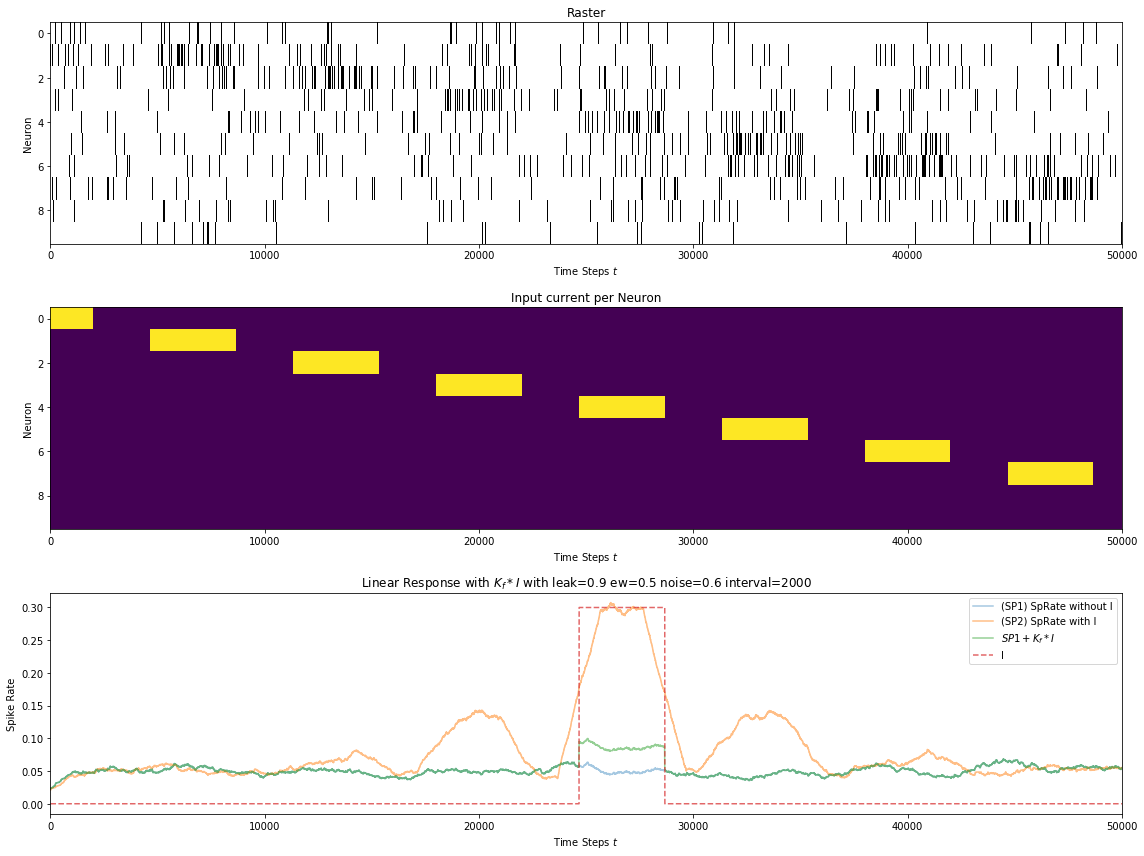

In [11]:
def linearResponse(N,interval,neuronA,raster1,raster2,current):
    T=25000*4
    interval=1000
    rA = np.array([np.sum(raster1[neuronA][int(max(0,t-interval/2)):int(min(t+interval/2,T))])
                   for t in range(int(T-interval/2))])/interval
    rA2 = np.array([np.sum(raster2[neuronA][int(max(0,t-interval/2)):int(min(t+interval/2,T))])
                   for t in range(int(T-interval/2))])/interval
    sumTau = np.sum(np.vstack([tauCorr(raster1,neuronA,B,T) for B in range(N)]),axis=0)
    rA3 = np.convolve(current.T[neuronA],sumTau,"same")
    
    plt.figure(figsize=(16,12))
               
    plt.subplot(3,1,1)
    plt.title("Raster")
    plt.imshow(raster2,aspect="auto")

    plt.subplot(3,1,2)
    plt.title("Input current per Neuron")
    plt.imshow(current.T,aspect="auto")

    plt.subplot(3,1,3)
    plt.title("$Corr(t)$")
    plt.xlim(0,T)
    #plt.plot(range(int(T-interval/2)),rA,label="$SR1$".format(neuronA),alpha=0.5)
    plt.plot(range(int(T-interval/2)),rA2,label="$SR2$".format(neuronA),alpha=0.5)
    plt.plot(range(int(T-interval/2)),rA3[:int(T-interval/2)]+rA,label="$SR1+Kf*I$".format(neuronA),alpha=0.5)
    #plt.plot(range(T),current.T[neuronA])
    plt.legend()
    return rA,rA2,rA3[:int(T-interval/2)],sumTau,current.T[neuronA]

def linearResponseLoader(interval,leak,ew,noise,tcurrent,neuronA):
    mode = BMS(N,leak,noise,threshold,randomV0)
    with open("Rasters/RG{0}E{1}N{2}C1.pkl".format(leak,ew,noise,1),"rb") as WF:
        raster1 = pkl.load(WF)
    with open("Rasters/RG{0}E{1}N{2}C{3}.pkl".format(leak,ew,noise,tcurrent),"rb") as WF:
        raster2 = pkl.load(WF)
    if tcurrent==2:
        current = current2
    else:
        current = current3
    rA = np.array([np.sum(raster1[neuronA][int(max(0,t-interval/2)):int(min(t+interval/2,T))])
                   for t in range(int(T-interval/2))])/interval
    rA2 = np.array([np.sum(raster2[neuronA][int(max(0,t-interval/2)):int(min(t+interval/2,T))])
                   for t in range(int(T-interval/2))])/interval
    sumTau = np.sum(np.vstack([tauCorr(raster1,neuronA,B,T) for B in range(N)]),axis=0)
    rA3 = np.convolve(current.T[neuronA],sumTau,"same")
    mode.raster = raster1
    #Kf = np.sum(np.vstack([mode.PWC(neuronA,i,interval,0) for i in range(N) if i!=neuronA])/(N-1),axis=0)
    #KxS = np.convolve(Kf,current.T[neuronA],"same")
    
    plt.figure(figsize=(16,4*3))
    st,en = 0,50000
    plt.subplot(3,1,1)
    plt.xlim(st,en)
    plt.xlabel('Time Steps $t$')
    plt.ylabel('Neuron')
    plt.title("Raster")
    plt.imshow(raster2,aspect="auto",cmap='binary')

    

    plt.subplot(3,1,2)
    plt.title("Input current per Neuron")
    plt.xlim(st,en)
    plt.xlabel('Time Steps $t$')
    plt.ylabel('Neuron')
    plt.imshow(current.T,aspect="auto")
    #plt.plot(range(rA2.shape[0]),rA2)
    #plt.title('SpikeRate')

    plt.subplot(3,1,3)
    
    plt.title("Linear Response with $K_f*I$ with leak={0} ew={1} noise={2} interval={3}".format(leak,ew,noise,interval))
    #plt.xlim(0,T)
    plt.xlim(st,en)
    plt.xlabel('Time Steps $t$')
    plt.ylabel('Spike Rate')
    
    plt.plot(range(int(T-interval/2)),rA,label="(SP1) SpRate without I".format(neuronA),alpha=0.4)
    plt.plot(range(int(T-interval/2)),rA2,label="(SP2) SpRate with I".format(neuronA),alpha=0.5)
    plt.plot(range(int(T-interval/2)),rA3[:int(T-interval/2)]+rA,label="$SP1+K_f*I$".format(neuronA),alpha=0.5)
    #plt.plot(range(int(T-interval/2)),3*rA3[:int(T-interval/2)]+rA,label="$SR1+(Kf*I)*3$".format(neuronA),alpha=0.5)
    plt.plot(range(T),current.T[neuronA],'--',label='I',alpha=0.7)
    #plt.plot(range(T),rA3,'--',label='$K_f*I$',alpha=0.7)
    #plt.plot(range(T),KxS,'--',label='$K_f*I$',alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig('lr.svg')
    plt.show()
    
    return rA,rA2,rA3[:int(T-interval/2)],sumTau,current.T[neuronA]

#rateSp,rateI,conv,Kf,I = linearResponse(10,40,4,raster1,raster3,current3)
#   leak, ew, noise [0.5,0.7,0.9] [0.2,0.5,0.7]  [0.3,0.5,0.6,0.8]
rateSp,rateI,conv,Kf,I = linearResponseLoader(2000,0.9,0.5,0.6,2,4)


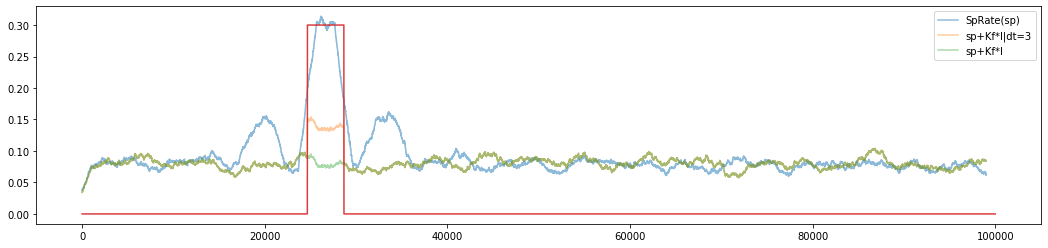

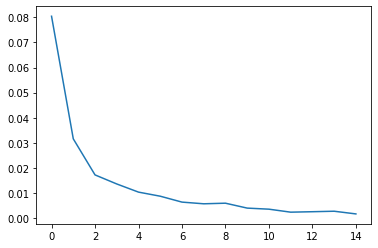

In [5]:
#Plot testing section
plt.figure(figsize=(18,4))
#plt.plot(range(Kf.shape[0]),Kf)
plt.plot(range(rateSp.shape[0]),rateI,alpha=0.5,label='SpRate(sp)')
#plt.plot(range(rateSp.shape[0]),rateSp+conv*2,alpha=0.4)
plt.plot(range(rateSp.shape[0]),rateSp+conv*1,alpha=0.4,label='sp+Kf*I|dt=3')
plt.plot(range(rateSp.shape[0]),rateSp,alpha=0.4,label='sp+Kf*I')
plt.plot(range(T),I,alpha=0.9)
plt.legend()
plt.show()
plt.plot(range(len(Kf)),Kf)
plt.show()

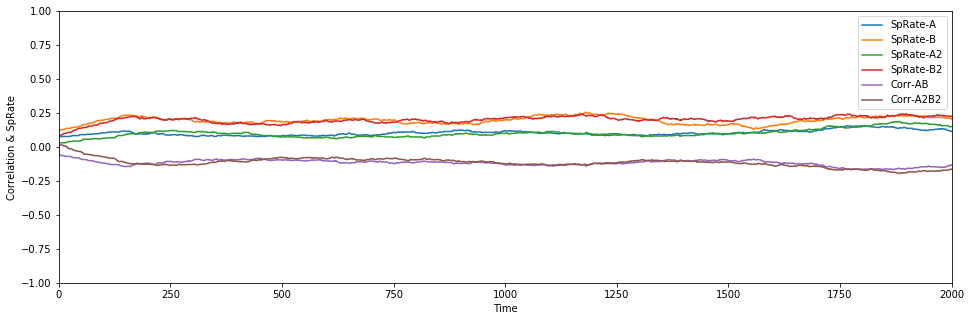

In [12]:
#Correlation between poisson variables
def PairwiseTest():
    T = 3000
    interval = 300
    X = np.array([1 if x>5 else 0 for x in np.random.poisson(4,T)])
    Y = np.array([1 if x>5 else 0 for x in np.random.poisson(5,T)])
    Z = np.array([1 if x>5 else 0 for x in np.random.poisson(6,T)])

    A = np.array([1 if X[x]+Z[x]>1 else 0 for x in range(T)])
    B = np.array([1 if Y[x]+Z[x]>1 else 0 for x in range(T)])

    sprates = [
        np.array([np.sum(A[int(max(0,t-interval/2)):int(min(t+interval/2,T))])for t in range(int(T-interval/2))])/interval,
        np.array([np.sum(B[int(max(0,t-interval/2)):int(min(t+interval/2,T))])for t in range(int(T-interval/2))])/interval
    ]

    A2 = np.array([1 if np.random.random()<sprates[0][t] else 0 for t in range(T-interval)])
    B2 = np.array([1 if np.random.random()<sprates[1][t] else 0 for t in range(T-interval)])
    sprates2 = [
        np.array([np.sum(A2[int(max(0,t-interval/2)):int(min(t+interval/2,T))])for t in range(int(T-interval/2))])/interval,
        np.array([np.sum(B2[int(max(0,t-interval/2)):int(min(t+interval/2,T))])for t in range(int(T-interval/2))])/interval
    ]


    C1 = PWC(A,B,interval,T,3)[0]
    C2 = PWC(A2,B2,interval,T,3)[0]

    plt.figure(figsize=(16,5))
    plt.xlabel("Time")
    plt.ylabel("Correlation & SpRate")
    plt.ylim(-1,1)
    plt.xlim(0,2000)
    plt.plot(range(int(T-interval/2)),sprates[0],label="SpRate-A")
    plt.plot(range(int(T-interval/2)),sprates[1],label="SpRate-B")
    plt.plot(range(int(T-interval/2)),sprates2[0],label="SpRate-A2")
    plt.plot(range(int(T-interval/2)),sprates2[1],label="SpRate-B2")
    #plt.plot(range(int(T-interval/2)),C1,label="Corr-AB")
    #plt.plot(range(int(T-interval/2)),C2,label="Corr-A2B2")
    plt.plot(range(T),C1,label="Corr-AB")
    plt.plot(range(T),C2,label="Corr-A2B2")
    plt.legend()
    plt.show()

PairwiseTest()

### Testing Discrete and continuous convolution

[1 2 3 4] [3 5 1 2] 
upper code: [ 3. 11. 20. 31. 27. 10.  8.] 
down code: [ 3 11 20 31 27 10  8] 
numpy function: [3, 11, 20, 31, 27, 10, 8]


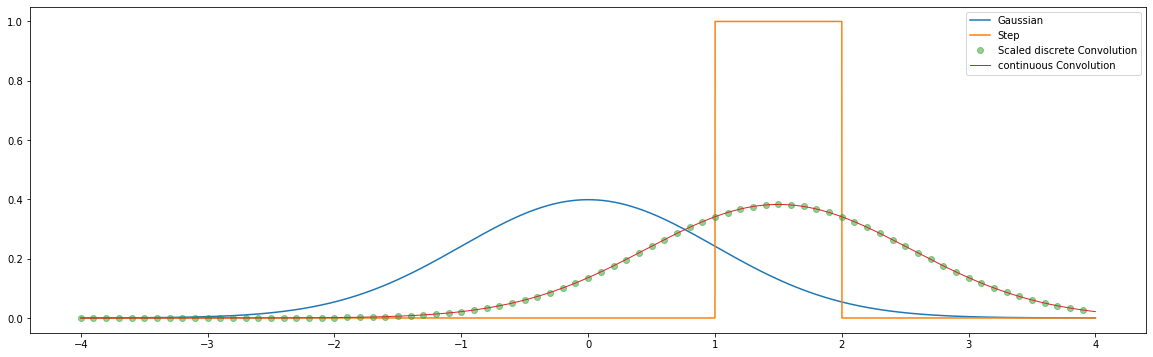

In [12]:
A = np.array([1,2,3,4])
B = np.array([3,5,1,2])

def convolution (stimulus, temporalfilter) :
    Vt = np.zeros(len(stimulus)+len(temporalfilter)-1)
    for t in range(len(Vt)):
         for j in range(len(temporalfilter)):
            if t-j<0:
                continue
            if t-j >=len(stimulus):
                continue
            Vt[t] += stimulus[t-j] * temporalfilter[j]
    return Vt


def singlelineconvo(A,B):
    return [sum([A[t-j]*B[j] for j in range(len(B)) if t-j>=0 and t-j<len(A)]) for t in range(len(A)+len(B)-1)]

print(A,B, "\nupper code:",convolution(A,B),
      "\ndown code:",np.convolve(A,B,"full"),
      "\nnumpy function:",singlelineconvo(A,B))

x = np.arange(-4,4,0.001)
g = np.exp(-x**2/2)/np.sqrt(2*np.pi)
s = [1.0 if 1.0<=n<=2.0 else 0 for n in x]
ec = (-np.sqrt(np.pi/2)*(1 + erf((-2 + x)/np.sqrt(2))) + 
      np.sqrt(np.pi/2)*(1 + erf((-1 + x)/np.sqrt(2))))/np.sqrt(2*np.pi)

plt.figure(figsize=(20,6))
plt.plot(x,g,label="Gaussian")
plt.plot(x,s,label="Step")
plt.plot(x[::100],np.convolve(s,g,"same")[::100]*0.001,"o",label="Scaled discrete Convolution",alpha=0.5)
plt.plot(x,ec,linewidth=1,label="continuous Convolution")
plt.legend()
